In this notebook, I'm going to try my hand at the Lyft Udacity challenge: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge. I'm going to build a U-Net, a variety of Fully Convolutional Neural Network first developed in this paper: https://arxiv.org/pdf/1411.4038.pdf. Ideally, my GPU ought to be able to handle this, since this paper was in 2015 and my GPU is top-line by those standards (but it might depend on how big the data is). Let's load and preprocess the data.

Note: this notebook is somewhat hacked-together from a few other kaggle solutions and tutorials to this and other semantic segmentation problems- the way I process the data (using a custom model) is original, but a decent amount of the syntax is not! I'll likely continue tuning this to improve performance, for now, the model architecture I'm using as a naive first-pass is taken from here: https://www.kaggle.com/binh234/semantic-segmentation-for-self-driving-cars

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, ELU 
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import glob
import random
import cv2

Define some parameters.

In [2]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
N_CLASSES = 13
BATCH_SIZE = 16
EPOCHS = 100
src_dir = '/home/garrett/KagglesData/SelfDriving'

Read in all images, train test split, and store images and masks in a pandas dataframe for use with the FlowFromDataframe ImageDataGenerator method.

In [3]:
input_imgs_names = []
mask_names = []

for i in ['A', 'B', 'C', 'D', 'E']:
    input_imgs_names += glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraRGB/*.png'))
    mask_names += glob.glob(os.path.join(src_dir, f'data{i}/data*/CameraSeg/*.png'))

num_samples = len(mask_names)
df = pd.DataFrame({'images':input_imgs_names , 'masks': mask_names})
df.reset_index(drop=True, inplace=True)
df.head(5)

XY_train,XY_valtest = train_test_split(df, train_size=0.8, random_state=0)
XY_val, XY_test = train_test_split(XY_valtest, train_size=0.5, random_state=0)
XY_train.reset_index(drop=True, inplace=True)
XY_val.reset_index(drop=True, inplace=True)
XY_test.reset_index(drop=True, inplace=True)

XY_train.head(5)

,images,masks
0,/home/garrett/KagglesData/SelfDriving/dataC/da...,/home/garrett/KagglesData/SelfDriving/dataC/da...
1,/home/garrett/KagglesData/SelfDriving/dataD/da...,/home/garrett/KagglesData/SelfDriving/dataD/da...
2,/home/garrett/KagglesData/SelfDriving/dataA/da...,/home/garrett/KagglesData/SelfDriving/dataA/da...
3,/home/garrett/KagglesData/SelfDriving/dataA/da...,/home/garrett/KagglesData/SelfDriving/dataA/da...
4,/home/garrett/KagglesData/SelfDriving/dataB/da...,/home/garrett/KagglesData/SelfDriving/dataB/da...


Let's get a random test image and look at the image and its mask, to make sure they match. Only the last channel of the mask image contains the masks.

(-0.5, 799.5, 599.5, -0.5)

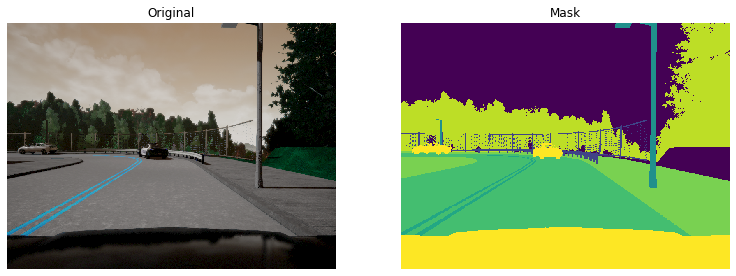

In [4]:
index = random.randint(0, len(XY_train)-1)
img = cv2.imread(XY_train.loc[index].at["images"])
mask = cv2.imread(XY_train.loc[index].at["masks"])[:,:,2]

plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

In [5]:
image_train_datagen = ImageDataGenerator(rescale=1./255.)
mask_train_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_train_generator = image_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="images",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
mask_train_generator = mask_train_datagen.flow_from_dataframe(
    dataframe=XY_train,
    x_col="masks",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_train_generator, mask_train_generator)

Found 4000 validated image filenames.
Found 4000 validated image filenames.


In [6]:
image_val_datagen = ImageDataGenerator(rescale=1./255.)
mask_val_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_val_generator = image_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="images",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
mask_val_generator = mask_val_datagen.flow_from_dataframe(
    dataframe=XY_val,
    x_col="masks",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
# combine generators into one which yields image and masks
val_generator = zip(image_val_generator, mask_val_generator)

Found 500 validated image filenames.
Found 500 validated image filenames.


In [7]:
image_test_datagen = ImageDataGenerator(rescale=1./255.)
mask_test_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_test_generator = image_test_datagen.flow_from_dataframe(
    dataframe=XY_test,
    x_col="images",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
mask_test_generator = mask_test_datagen.flow_from_dataframe(
    dataframe=XY_test,
    x_col="masks",
    class_mode=None,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    seed=seed)
# combine generators into one which yields image and masks
test_generator = zip(image_test_generator, mask_test_generator)

Found 500 validated image filenames.
Found 500 validated image filenames.


In [8]:
for x, y in train_generator:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256, 3))

(-0.5, 255.5, 255.5, -0.5)

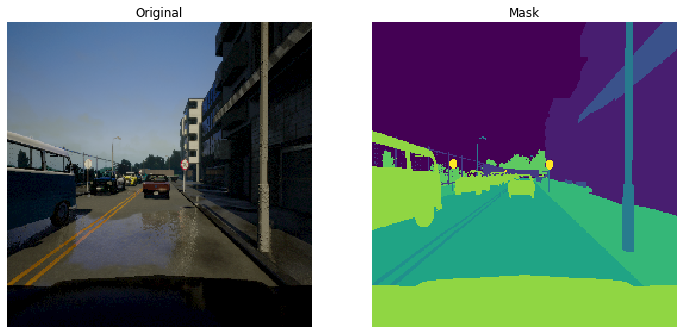

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[4])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[4,:,:,0])
plt.title('Mask')
plt.axis('off')

In [10]:
class CustomModel(Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, fully = data
        y = fully[:,:,:,0]
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        # Unpack the data
        x, fully = data
        y = fully[:,:,:,0]
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

Instead of using Batchnorm + RELU like some of the other solutions, I'm using ELU. I'm also specifying He normal initialization, since He typically does better than Glorot on deep networks.

In [20]:
def UNet():

    main_input = Input(shape=(HEIGHT, WIDTH, CHANNELS), name = 'img_input')

    ''' ~~~~~~~~~~~~~~~~~~~ ENCODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    c1 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(main_input)
    c1 = ELU()(c1)
    c1 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c1)
    c1 = ELU()(c1)

    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p1)
    c2 = ELU()(c2)
    c2 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c2)
    c2 = ELU()(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p2)
    c3 = ELU()(c3)
    c3 = Conv2D(32*2, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)
    c3 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c3)
    c3 = ELU()(c3)

    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p3)
    c4 = ELU()(c4)
    c4 = Conv2D(32*4, kernel_size=(1,1), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)
    c4 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c4)
    c4 = ELU()(c4)

    p4 = MaxPooling2D((2,2))(c4)

    c5 = Conv2D(32*6, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(p4)
    c5 = ELU()(c5)


    ''' ~~~~~~~~~~~~~~~~~~~ DECODING LAYERS ~~~~~~~~~~~~~~~~~~~ '''

    u1 = UpSampling2D((2,2))(c5)
    concat1 = Concatenate()([c4, u1])

    c6 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat1)
    c6 = ELU()(c6)
    c6 = Conv2D(32*4, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c6)
    c6 = ELU()(c6)


    u2 = UpSampling2D((2,2))(c6)
    concat2 = Concatenate()([c3, u2])

    c7 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat2)
    c7 = ELU()(c7)
    c7 = Conv2D(32*2, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c7)
    c7 = ELU()(c7)

    u3 = UpSampling2D((2,2))(c7)
    concat3 = Concatenate()([c2, u3])

    c8 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(concat3)
    c8 = ELU()(c8)
    c8 = Conv2D(32, kernel_size=(3,3), kernel_initializer='he_normal', padding = 'same')(c8)
    c8 = ELU()(c8)

    u4 = UpSampling2D((2,2))(c8)
    concat4 = Concatenate()([c1, u4])

    c9 = Conv2D(16, kernel_size = (1,1), kernel_initializer='he_normal', padding = 'same')(concat4)
    c9 = ELU()(c9)

    mask_out = Conv2D(13, (1,1), kernel_initializer='he_normal', padding = 'same', activation = 'sigmoid', name = 'mask_out')(c9)

    model = CustomModel(inputs = [main_input], outputs = [mask_out])
    
    return model

In [23]:
model = UNet()
model.summary()

Model: "custom_model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 32) 896         img_input[0][0]                  
__________________________________________________________________________________________________
elu_18 (ELU)                    (None, 256, 256, 32) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 32) 9248        elu_18[0][0]                     
_____________________________________________________________________________________

In [24]:
def lrfn(epoch):
    if epoch > 15:
        return 2e-4
    elif epoch > 25:
        return 1e-4
    return 1e-3

In [25]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [26]:
# Learning rate callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step))
# Model checkpoint, saves weights if val loss reduces
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', 'val_loss', save_best_only=True, save_weights_only=True, verbose=1)

In [ ]:
train_steps = len(image_train_generator)
print(train_steps)
val_steps = len(image_val_generator)
print(val_steps)

history = model.fit(train_generator, validation_data=val_generator, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 30, verbose=1, callbacks=[checkpoint, lr_callback])

250
32
Epoch 1/30
185/250 [=====================>........] - ETA: 3:42 - loss: 1.4159 - accuracy: 0.6060

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'Train acc')
plt.plot(history.history['val_accuracy'], label = 'Val acc')
plt.title('Accuracy')
plt.legend()

plt.figure()
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('loss')
plt.legend()

In [ ]:
model.save_weights('lastest.h5')
model.load_weights('model.h5')

In [22]:
score, acc = model.evaluate(test_generator,
                            batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)

NameError: name 'batch_size' is not defined

In [ ]:
max_show = 12
test_iter = iter(test_generator)
for i in range(max_show):
    images, masks = next(test_iter)
    masks = masks[:,:,:,0]
    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(pred_masks[i])
    ax[1].set_title('Prediction')
    
    ax[2].imshow(masks[i])
    ax[2].set_title('Ground truth')
    plt.savefig(f"pred_{i}.jpg", dpi=150)
    plt.show()